# ADA final exam (Fall 2024)

This exam consists of 2 tasks. The two tasks are independent of each other. You can solve them in any order.

## Task 1: Natural Language Processing (50 pts)
This part of the exam will analyze a real-world negotiation dataset:

Two participants take the role of campsite neighbors and negotiate for Food, Water, and Firewood packages, based on their individual preferences and requirements. This design keeps the task tractable, while still facilitating linguistically rich and personal conversations.

At the end of each negotiation, both negotiators receive an outcome score (`outcome`) reflecting their success in achieving their goals. The dataset is divided into two data frames:

1. `df_negotiations`, with columns:
    - `negotiation_id`: the negotiation identifier
    - `agent`: the agent active in that turn, either `mt_agent_1` or `mt_agent_2` (first and second to interact)
    - `message`: the message sent to the other agent
    - `turn`: the negotiation turn
2. `df_meta`, meta information for each negotiation with the outcome and agent background:
    - `gender`: (male, female, other)
    - `age`: integer
    - `outcome`: integer

We are interested in finding out: what makes a good (/bad) negotiator?

### Part 1: Coding Questions (29 pt)

In [1]:
import pandas as pd

df_negotiations = pd.read_csv('negotiations.csv')
df_negotiations.head()

,agent,message,negotiation_id,turn
0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,0,0
1,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,0,0
2,mturk_agent_1,I need firewood as well. We have a large group...,0,1
3,mturk_agent_2,I see. 😮 What are you least interested in?,0,1
4,mturk_agent_1,We can make do without extra water. Can we tra...,0,2


In [2]:
df_meta = pd.read_csv('negotiations_meta.csv')
df_meta.head()

,agent,age,gender,negotiation_id,outcome
0,mturk_agent_1,31,female,797,21
1,mturk_agent_2,26,male,797,15
2,mturk_agent_1,65,male,909,18
3,mturk_agent_2,34,female,909,23
4,mturk_agent_1,26,male,135,26


**1.1 (2 pt)**
/Discussion:/ We are interested in analyzing negotiation outcomes by analyzing language usage. In order to use TF-IDF to accomplish this, we will treat all turns from one negotiator in a single negotiation as a "document". Why would this definition of "document" be preferred over the following two alternatives? Give at least one argument per alternative.

- A) Each individual turn is a document
- B) The entire negotiation dialogue of both negotiators is a document

<div class="alert alert-block alert-info">

A) Because the outcome score is likely dependant on the language used throughout the negotiation and not only during a single turn. I.e. a turn might have been bad for the negotiator but the overall negotation was a success.

B) Because not both negotiators receive the same outcome score. They also don't use the same language which would make the features less distinctive.

</div>

**1.2 (3 pt)**

[A, 1 pt] Use the negotiation dataset to create a new dataframe called `df_document` with the following columns:
- `negotiation_id`
- `agent`
- `document`

Here, document is defined as described in question 1.1. That is: concatonate messages into a single string and split by the special character `"\n"`.

In [21]:
df_document = df_negotiations.groupby(["negotiation_id", "agent"]).aggregate(
    {"message":lambda messages: "\n".join(messages)}
).reset_index().rename(columns={"message":"document"})
df_document


,negotiation_id,agent,document
0,0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...
1,0,mturk_agent_2,Hey! I'd like some more firewood to keep my do...
2,1,mturk_agent_1,I am good. I am pretty excited for the trip th...
3,1,mturk_agent_2,Hello. How are you?\nVery excited. It will be ...
4,2,mturk_agent_1,Hi! How are you?! You excited for your camping...
...,...,...,...
2051,1027,mturk_agent_2,"Hello, I'm very excited for my trip, how about..."
2052,1028,mturk_agent_1,Hi. I am pretty excited to take my son and his...
2053,1028,mturk_agent_2,"Hey, I am also going camping but I am taking m..."
2054,1029,mturk_agent_1,"Hello! I totally get it. But, since my nephew ..."


[B, 2pt] Next, merge this new dataframe with the `df_meta` dataframe. Print the the size and first five rows of the final dataframe

In [22]:
df_document = pd.merge(
    df_document,
    df_meta,
)
print(f"{df_document.shape=}")
print(f"{df_document.size=}")
display(df_document.head(5))

df_document.shape=(2056, 6)
df_document.size=12336


,negotiation_id,agent,document,age,gender,outcome
0,0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,43,male,19
1,0,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,22,female,18
2,1,mturk_agent_1,I am good. I am pretty excited for the trip th...,24,female,19
3,1,mturk_agent_2,Hello. How are you?\nVery excited. It will be ...,43,female,17
4,2,mturk_agent_1,Hi! How are you?! You excited for your camping...,30,female,14


**1.3 (7 pt)**
We would like to analyze the difference between "best" and "worst" performers based on `outcome`, top and bottom 10% respectively.

[A, 2 pt] Find the top and bottom 10% thresholds for the `outcome` columns and print them.

In [23]:
import numpy as np

bottom_10pct_treshold = np.percentile(df_document.sort_values(by="outcome")["outcome"], 10.0)
top_10pct_treshold = np.percentile(df_document.sort_values(by="outcome")["outcome"], 90.0)

print(f"{bottom_10pct_treshold=}")
print(f"{top_10pct_treshold=}")

bottom_10pct_treshold=15.5
top_10pct_treshold=23.0


[B, 1pt] Create a TF-IDF matrix using the `TfidfVectorizer` form `sklearn`, setting `max_features=100` and `stop_words="english"`. Print the resulting TF-IDF matrix shape.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
X = vectorizer.fit_transform(df_document["document"])

print(f"Resulting TF-IDF matrix shape: {X.shape}")

Resulting TF-IDF matrix shape: (2056, 100)


[C, 4pt] Use your thresholds and the TF-IDF matrix to print the top 10 terms for each type of negotiatior (i.e., the best and worst performing negotiators from question 1.3.A).

In [48]:
top_10_terms_for_worst_negotiators = vectorizer.get_feature_names_out()[
    np.argsort(X[df_document.query(f"outcome <= {bottom_10pct_treshold}").index].toarray().sum(axis=0))[-10:]
]
print(f"Worst negotiation terms :\n {top_10_terms_for_worst_negotiators}")

Worst negotiation terms :
 ['submit' 'package' 'like' 'packages' 'extra' 'deal' 'need' 'firewood'
 'water' 'food']


In [49]:
top_10_terms_for_best_negotiators = vectorizer.get_feature_names_out()[
    np.argsort(X[df_document.query(f"outcome >= {top_10pct_treshold}").index].toarray().sum(axis=0))[-10:]
]
print(f"best negotiation terms :\n {top_10_terms_for_best_negotiators}")

best negotiation terms :
 ['good' 'submit' 'like' 'camping' 'extra' 'deal' 'need' 'firewood' 'water'
 'food']


**1.4 (8 pt)**
You never get a second chance at a first impression! Let's investigate if the same goes for negotiations...

[A, 1pt] Create a new df_document that only takes into account the first three (3) turns of each negotiator in a negotiation. Again, merge on the df_meta dataframe and print the resulting size.

In [55]:
def join_messages(messages):
    return  "\n".join(messages[:3])

df_document = df_negotiations.sort_values("turn").groupby(["negotiation_id", "agent"]).aggregate(
    {"message":join_messages}
).reset_index().rename(columns={"message":"document"})

df_document = pd.merge(
    df_document,
    df_meta,
)
print(f"{df_document.shape=}")
print(f"{df_document.size=}")
display(df_document.head(5))

df_document.shape=(2056, 6)
df_document.size=12336


,negotiation_id,agent,document,age,gender,outcome
0,0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,43,male,19
1,0,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,22,female,18
2,1,mturk_agent_1,I am good. I am pretty excited for the trip th...,24,female,19
3,1,mturk_agent_2,Hello. How are you?\nVery excited. It will be ...,43,female,17
4,2,mturk_agent_1,Hi! How are you?! You excited for your camping...,30,female,14


[B, 1pt] Calculate the median negotiation outcome. Then, add a column called success to the df_document dataframe that is 1 if the outcome column is more than the median and 0 otherwise. Print the median outcome.

In [60]:
median_negotiation_outcome = df_document.describe().loc["50%", "outcome"]
df_document["success"] = (df_document["outcome"] > median_negotiation_outcome).astype(int)
df_document

,negotiation_id,agent,document,age,gender,outcome,success
0,0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,43,male,19,0
1,0,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,22,female,18,0
2,1,mturk_agent_1,I am good. I am pretty excited for the trip th...,24,female,19,0
3,1,mturk_agent_2,Hello. How are you?\nVery excited. It will be ...,43,female,17,0
4,2,mturk_agent_1,Hi! How are you?! You excited for your camping...,30,female,14,0
...,...,...,...,...,...,...,...
2051,1027,mturk_agent_2,"Hello, I'm very excited for my trip, how about...",37,male,19,0
2052,1028,mturk_agent_1,Hi. I am pretty excited to take my son and his...,63,female,22,1
2053,1028,mturk_agent_2,"Hey, I am also going camping but I am taking m...",29,male,18,0
2054,1029,mturk_agent_1,"Hello! I totally get it. But, since my nephew ...",35,male,18,0


[C, 2pt] Create a TF-IDF matrix called `X` based on `df_document` using the following settings:

`max_features=100, stop_words="english, ngram_range=(1, 2)`

Additionally, create a variable `y` that corresponds to the success column. Finally, use `sklearn.model_selection.train_test_split` to split your data into a train and test set using parameters `test_size=0.2` and `random_state=99`.

Print the shape of the TF-IDF and the shape of your train and test sets.

In [61]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=100, stop_words="english", ngram_range=(1, 2))
X = vectorizer.fit_transform(df_document["document"])
y = df_document["success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

print(f"Shape of TF-IDF matrix : {X.shape}")
print(f"{X_train.shape=}, {y_train.shape=}")
print(f"{X_test.shape=}, {y_test.shape=}")

Shape of TF-IDF matrix : (2056, 100)
X_train.shape=(1644, 100), y_train.shape=(1644,)
X_test.shape=(412, 100), y_test.shape=(412,)


[D, 2pt] Use your prepared data to train a logistic regression model (`sklearn.linear_model.LogisticRegression`). Then, with the trained model predict on the test set and print a classification report (`sklearn.metrics.classification_report`).

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression().fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76       264
           1       0.29      0.04      0.07       148

    accuracy                           0.62       412
   macro avg       0.46      0.49      0.42       412
weighted avg       0.51      0.62      0.51       412



[E, 2pt] Use the weights of your trained model to show which terms mostly strongly correlate with high and low outcomes. Print the best five terms for each.

In [71]:
best_five_terms_low = vectorizer.get_feature_names_out()[np.argsort(clf.coef_.flatten())[:5]]

best_five_terms_high = vectorizer.get_feature_names_out()[np.argsort(clf.coef_.flatten())[-5:]]

print(f"Best five terms for high outcomes:\n{best_five_terms_high}")

print(f"Best five terms for low outcomes:\n{best_five_terms_low}")

Best five terms for high outcomes:
['really need' 'night' 'nice' 'items' 'water']
Best five terms for low outcomes:
['know' 'extra firewood' 'food water' 'sure' 'today']


**1.5 (9 pt)**
You are concerned about potential “confounding” factors for your results in the previous question. Specifically, you would like to investigate the effect of “gender” on the outcomes.

[A, 3pt] Visualize the outcomes stratified by gender using a bar plot with standard deviation around the mean. Make sure you use clear x- and y-axis labels, a title, and a legend.

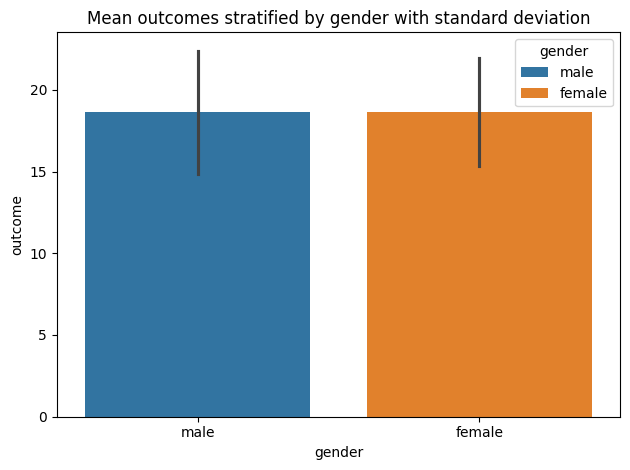

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.barplot(
    df_document,
    y="outcome",
    x="gender",
    hue="gender",
    errorbar="sd",
    legend=True,
)
ax.set_title("Mean outcomes stratified by gender with standard deviation")
plt.tight_layout()
plt.show()

[B, 2pt] Perform a T-Test with a confidence interval of 0.95 to check if the outcomes based on gender are statistically significantly different. Print the resulting t-statistic, the p-value, and your interpretation of the result.

In [132]:
from scipy.stats import ttest_ind

ttest_res = ttest_ind(
    df_document.query("gender == 'male'")["outcome"],
    df_document.query("gender == 'female'")["outcome"],
    equal_var = False
)
print(f"T-test statistic: {ttest_res.statistic}")
print(f"T-test pvalue: {ttest_res.pvalue}")

T-test statistic: -0.15192015475218326
T-test pvalue: 0.8792650642656046


<div class="alert alert-block alert-info">

The difference in outcomes between the two genders is non significant as with a 0.95 CI, alpha = 0.05 and the pvalue < alpha, hence we cannot reject the null hypothesis.

</div>

[C, 2pt] Finally, we would like to test if the gender distribution between high and low negotiation performers is significantly different. Please perform a chi-square test on the gender distribution of those negotiators scoring above the median outcome. Use a confidence interval of 0.95 and print the resulting chi-square statistic, p-value, and your interpretation of the result.

In [84]:
from scipy.stats import chisquare

# ...

<div class="alert alert-block alert-info">


</div>

[D, 2pt] /Discuss:/ In addition to the gender attribute, could you think of other measurable factors in this dataset that could be tested as confounders? List at least two more and explain why.

<div class="alert alert-block alert-info">

In addition, some additional confounders in the dataset could be:

- The number of turns of the negotiations: a higher number of turns could mean that both sides are trying to maximise their outcome.

- The age of the agent that is doing the negotiation: might be correlated to age discrimination i.e. if the agent is young or young you do not accept, hence a low outcome.

</div>

### Part 2: Insight Questions (15 pt)

**2.1 (3pt)**
In the context of analyzing negotiation turns, why would TF-IDF be more suitable than simple word frequency counts when trying to identify distinctive communication patterns between successful and unsuccessful negotiations?

<div class="alert alert-block alert-info">

The TF-IDF features are more suitable than the word frequency counts as per document, it multiplies the document frequencies counts by the inverse doc freq, hence making the documents more equilibrated.

</div>

**2.2 (2pt)**
How would you modify the standard TF-IDF implementation to account for the temporal nature of negotiation turns? Consider that early turns might be more important for setting the tone of the negotiation than later turns.

<div class="alert alert-block alert-info">

One might consider the following approach:

- First calculate the TF-IDF matrix over all TURNS

- For each agent conversation, aggregate all TURN vectors into a single DOCUMENT vector using a weighted average using the inverse of the number of turns (`turn` column in df) as weights.

</div>

**2.3 (3 pt)**
In our negotiation dataset, successful negotiators might simply write longer messages. How could this create a misleading interpretation of our TF-IDF results, and what would be a simple way to test for this potential bias?

<div class="alert alert-block alert-info">

If successful negotiators write longer messages, 

To test for this bias one could 

</div>

**2.4 (3pt)**
In our negotiation dataset, consider these two opening messages from different agents:

Agent A: "I propose we split the resources fairly" Agent B: "I suggest we divide the assets equitably"

These messages are semantically very similar but use different vocabulary. Explain:

- a) How TF-IDF would process these messages differently
- b) How word embeddings (like Word2Vec) would handle them
- c) Why this distinction matters for negotiation analysis

<div class="alert alert-block alert-info">

a) TF-IDF will process these messages differently as "propose" versus "suggest", "split" vesrus "divide", "assests" versus "resources" and "farily" versus "equitably" are different words. as such the token freqeuncy of each would go up by one and they would get normalised by the inverse doccument frequency. Hence the two vectors would have simmilar values but not in the same index positions.

b) Word embedding take the semantic relevance of the given text. Hence the output embeddinggs of both would be relatively simmilar.

c) This distinction matters because these opening messages are semantically simmilar and as such their feature vectors should be the similar. 

</div>

**2.5 (4pt)**
Staying in the context of negotiations, explain why N-gram models such as bigrams might be more informative than unigrams for predicting negotiation outcomes. Provide two examples of bigrams that would be particularly meaningful in negotiation contexts but would lose their significance if split into unigrams.

<div class="alert alert-block alert-info">

Ngram models might be more informative as for example if you want a combination of food and water, whereas you just want one or the other (i.e. "food, water" versus "water") the negotation might be easier since you are only asking as an easy combination.

</div>

## Task 2: Analysis of Co-Author Network (50 pts)


In this part, you will analyze a reserach publication dataset derived from 
[social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf) (the paper itself is irrelevant to this exam, don't waste time reading it).

The citation data is extracted from DBLP, ACM, MAG (Microsoft Academic Graph), and other sources. Each paper is associated with abstract, authors, year, venue, and title.

Dataset: [citation dataset](https://cn.aminer.org/citation)

Paper: [social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf)


### Download data from the web

#### For Linux and MacOS:
```bash
wget https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip
unzip citation-network1.zip
ls -l outputacm.txt
```

#### For windows we recommend using WSL (Windows Subsystem for Linux) with above commands or directly downloading the file from the browser at 
https://lfs.aminer.cn/lab-datasets/citation



In [87]:
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

from helper import load_data_as_df


# Define the file path
file_path = "outputacm.txt"

# Load the data into a DataFrame
df = load_data_as_df(file_path)

# check if the index column is the same as the index 

print(f"Dataset loaded with {len(df)} entries.")
print(f"colums: {df.columns}")

Dataset loaded with 629814 entries.
colums: Index(['title', 'authors', 'year', 'venue', 'references', 'abstract'], dtype='object')


**3.1 (6 pts)**: Analyze Papers Published Per Year

**Objective:**  
Analyze and visualize publication trends to understand how the research field has evolved over time.

#### Instructions:
1. Group the data by the year of publication and count the number of papers for each year (2 pts).
2. Plot a bar chart showing the number of papers published per year from **1990 to 2010**. (2 pts)
3. Focus on the pattern between **1996 and 2004**:
   - **Discuss:** Describe any notable trends or changes in the number of publications during this period. (2 pts)
   - **Bonus:** Hypothesize potential reasons for the observed pattern.  (2 pts)
     *Hint: Consider events or trends related to the dataset's focus on computer science.* 


In [108]:
df.groupby("year").count().sort_index()

,title,authors,venue,references,abstract,nb_authors
year,,,,,,
1900.0,1,1,1,1,0,1
1941.0,1,1,1,1,0,1
1947.0,1,1,1,1,0,1
1949.0,1,1,1,1,0,1
1950.0,2,2,2,2,0,2
...,...,...,...,...,...,...
2007.0,38312,38312,38312,38312,32429,38312
2008.0,45378,45378,45378,45378,40393,45378
2009.0,42842,42842,42842,42842,38819,42842


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_4011/522856093.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


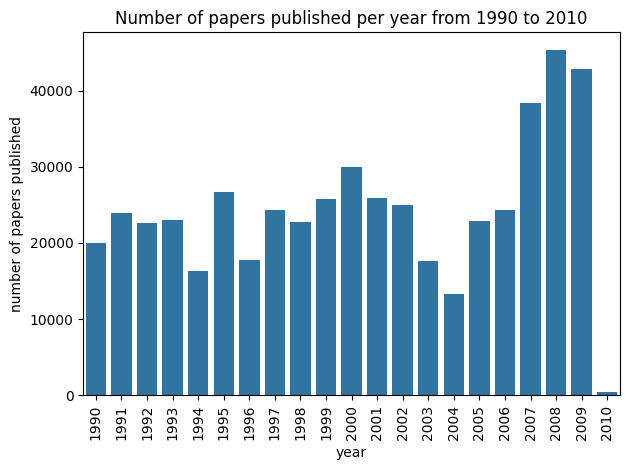

In [205]:
plot_df = df.groupby("year").count().reset_index().query("1990 <= year <= 2010")

plot_df["year"] = plot_df["year"].astype(int)

# plot_df["focus"] = 0
# plot_df.loc[plot_df.query("1996 <= year <= 2004").index, "focus"] = 1

ax = sns.barplot(
    plot_df,
    x="year",
    y="title",
    # hue="focus"
)
# ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("number of papers published")
ax.set_title("Number of papers published per year from 1990 to 2010")
plt.tight_layout()
plt.show()

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_4011/2576538797.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


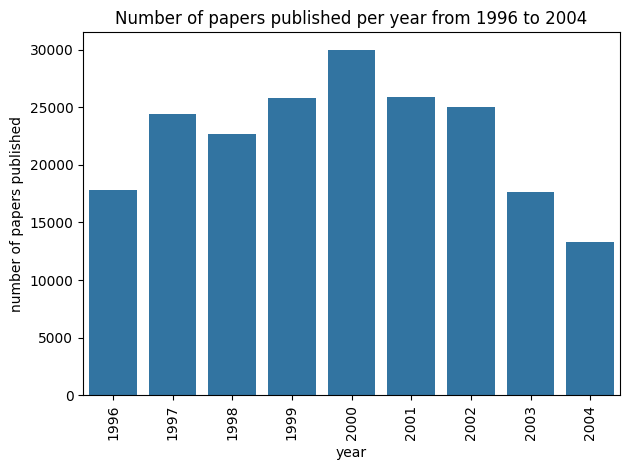

In [206]:


ax = sns.barplot(
    plot_df.query("1996 <= year <= 2004"),
    x="year",
    y="title",
    # hue="focus"
)
# ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("number of papers published")
ax.set_title("Number of papers published per year from 1996 to 2004")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

We can see an increasing trend from 1996 to 2000, a peak in 2000 and then a decreasing trend up to 2004

</div>

**3.2 (4 pts)**: Authors Per Paper Analysis

With the rise of interdisciplinary research, multi-authored papers are becoming more common. This task will help us understand collaboration dynamics in the academic world.

#### Instructions:
- Get the number of authors for each paper and calculate the percentage of papers with four or more authors. (2 pts)
- Plot a histogram to show the frequency distribution of the number of authors per paper (2 pts)(choose `bins=range(0, 30)` and set y-axis to log scale).

In [ ]:
df["nb_authors"] = df["authors"].apply(len)
pct_auths_sup_4 = len(df.query("nb_authors >= 4")) / len(df)
print(f" percentage of papers with four or more authors : {pct_auths_sup_4}")

 percentage of papers with four or more authors : 0.13173730656987617


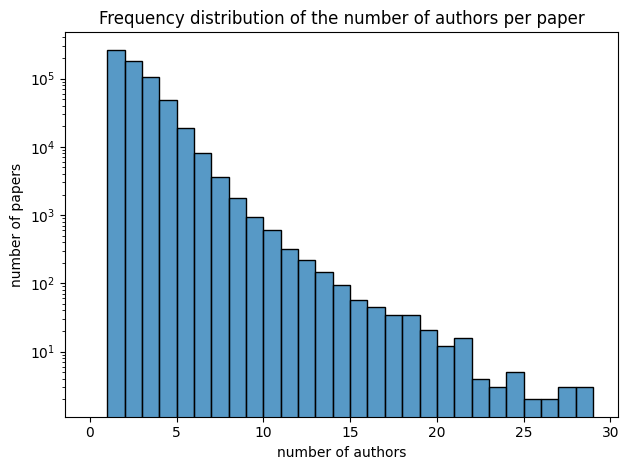

In [115]:
ax = sns.histplot(
    df,
    x="nb_authors",
    bins=range(0, 30)
)
ax.set_yscale("log")
ax.set_title("Frequency distribution of the number of authors per paper")
ax.set_ylabel("number of papers")
ax.set_xlabel("number of authors")
plt.tight_layout()
plt.show()

**3.3 (4 pts)**: Temporal Collaboration Trends

Collaboration dynamics can change over time. This task will help us understand how collaboration trends have evolved in the academic world.

#### Instructions:
- Group the data by publication year, calculate the average number of authors per paper for each year, and create a line plot to visualize how it has changed from 1990 to 2010 (1 pt).
- **Discuss:** There has been a hypothesis that the number of authors per paper has increased over time. Based on the plot, do you agree with this hypothesis ? (1 pt)
- Compute the P-value of the hypothesis that the average number of authors per paper after 2000 is significantly higher than before 2000. (2 pts)

In [117]:
# TODO
df.groupby("year").aggregate({"nb_authors":"mean"}).sort_index().reset_index().rename(columns={"nb_authors":"mean_nb_authors"})

,year,mean_nb_authors
0,1900.0,1.000000
1,1941.0,1.000000
2,1947.0,2.000000
3,1949.0,2.000000
4,1950.0,1.000000
...,...,...
61,2007.0,2.620667
62,2008.0,2.729605
63,2009.0,2.798189
64,2010.0,2.726316


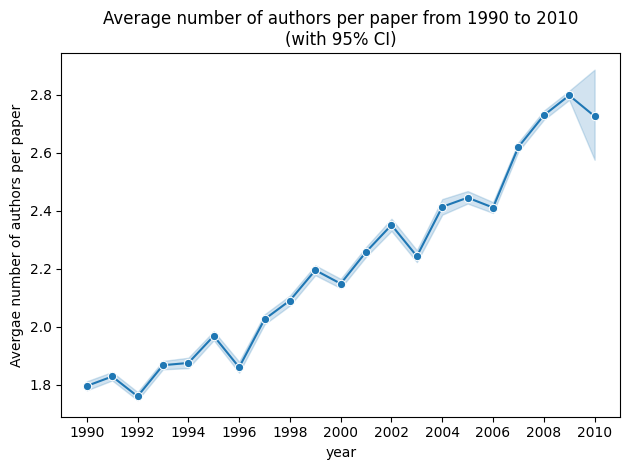

In [127]:
ax = sns.lineplot(
    df.query("1990<=year<=2010"),
    x="year",
    y="nb_authors",
    marker="o"
)
ax.set_ylabel("Avergae number of authors per paper")
ax.set_xticks(range(1990, 2011, 2))
ax.set_title("Average number of authors per paper from 1990 to 2010\n(with 95% CI)")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

From this plot we can clearly see that there has been an increase in the average number of authors per paper

</div>

In [130]:
ttest_res = ttest_ind(
    df.query("year >= 2000")["nb_authors"],
    df.query("year < 2000")["nb_authors"],
    alternative="greater"
)
print(f"T-test statistic: {ttest_res.statistic}")
print(f"T-test pvalue: {ttest_res.pvalue}")

T-test statistic: 194.86008664473866
T-test pvalue: 0.0


**3.4 (6 pts)**: Build a Co-Author Network

Co-author networks help us visualize and quantify collaborations in academia. Such networks are critical for identifying influential researchers and their role in fostering connections within their communities. Construct a network where nodes represent authors and edges represent collaborations.

#### Instructions:
- Create a graph where: (5 pts)
  - Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
  - Edges: There is an edge between two nodes if the corresponding authors have co-authored at least one paper. The weight of the edge represents the number of papers the two authors have co-authored together.
- After constructing the network, print the following information: (1 pt)
  - The total number of nodes (authors) in the network.
  - The total number of edges (collaborations) in the network.

Example:

For a paper authored by ["Alice", "Bob", "Charlie"], the graph should include:
- Nodes: Alice, Bob, Charlie.
- Edges: Alice-Bob, Alice-Charlie, Bob-Charlie, each with a weight of 1 (assuming no other collaborations between these pairs).


In [148]:
from itertools import combinations

In [163]:
def create_combinations(authors):
    return list(combinations(sorted(authors.iloc[0]), 2))

df_co_authors = df.reset_index().groupby("index").aggregate(
    {"authors":create_combinations}
)
df_co_authors

,authors
index,
0,"[(Dongming Wang, Hoon Hong)]"
1,[]
2,"[(Ahmed E. Hassan, Parminder Flora)]"
3,"[(Carlito Vicencio, Darrel Creacy)]"
4,"[(Anita Kesavan, Neil Daswani)]"
...,...
629809,[]
629810,[]
629811,"[(Alexandros Potamianos, Manolis Perakakis)]"


In [166]:
df_co_authors_exploded = df_co_authors.explode("authors").dropna()
df_co_authors_exploded["author_i"] = df_co_authors_exploded["authors"].apply(lambda tup : tup[0])
df_co_authors_exploded["author_j"] = df_co_authors_exploded["authors"].apply(lambda tup : tup[1])
df_edge_list = df_co_authors_exploded.groupby(["author_i", "author_j"]).count().reset_index()

In [173]:
import networkx as nx

G = nx.from_pandas_edgelist(df_edge_list.rename(columns={"authors": "weight"}), "author_i", "author_j", edge_attr=["weight"])

In [174]:
len(G.nodes()), len(G.edges())

(505027, 1137185)

**3.5 (4 pts)**: Analyze the Co-Author Network

Connected components in a co-author network can reveal isolated research communities or dominant research hubs. Analyzing the largest component helps us understand the core of academic collaboration

#### Instructions:
- The degree of a node is the number of edges connected to it. In the context of the co-author network, this represents the number of distinct co-authors an author has collaborated with. Compute the average degree of the network (1 pt).
- Connectivity of the Network:
  - A network is fully connected if there is a path between every pair of nodes. Determine if the co-author network is fully connected (2 pt). (Hint: A single answer is not enough here. You need to use a method to verify the connectivity of the network.)
  - Can you tell how many authors are part of the largest connected component? How much does this account for the total number of authors in the network? (2 pt)
<!-- - Compute the average clustering coefficient of the network. -->

In [179]:
print(f"Average degree of network : {np.mean(list(dict(G.degree()).values()))}")

Average degree of network : 4.503462191130375


In [188]:
print(f"Is the network connected : {nx.is_connected(G)}")

Is the network connected : False


In [187]:
largest_cc = max(nx.connected_components(G), key=len)
print(f"Number of authors in largest connected component {len(largest_cc)}")
print(f"Percentage of authors in largest connected component {len(largest_cc) / len(G.nodes())}")

Number of authors in largest connected component 342738
Percentage of authors in largest connected component 0.6786528245024523


**3.6 (4 pts)**: Top Authors by Collaborations

#### Instructions:
- Get the degree for all nodes in the network and print the top 10 authors by degree (1 pt) (Note: some entries (e.g., "II," "III," "Jr.") may not represent real authors due to data quality issues. Please keep them in the list and don't do any cleaning.)
- A high degree  indicates that an author has collaborated with many other authors. However, it does not consider if the collaborations happen multiple times between the same authors. A weighted degree would be a better measure to consider the number of collaborations between authors. Get the top 10 authors by weighted degree. P.S. The weighted degree is the sum of the weights of the edges connected to the node. (1 pt)
- Which two authors have the highest number of collaborations? How many papers have they co-authored together? (2 pt)

In [204]:
# TODO
degrees = dict(G.degree())
sorted_authors = sorted(degrees, key=degrees.get, reverse=True)

for i, author in enumerate(sorted_authors[:10]):
    print(f"Top {i+1} author name : {author} (degree = {degrees[author]})")


Top 1 author name :  Jr. (degree = 6343)
Top 2 author name :  III (degree = 1340)
Top 3 author name :  II (degree = 785)
Top 4 author name : Wei Wang (degree = 316)
Top 5 author name : Ming Li (degree = 242)
Top 6 author name : Wei Li (degree = 228)
Top 7 author name : Lei Zhang (degree = 203)
Top 8 author name : Elisa Bertino (degree = 197)
Top 9 author name : Hector Garcia-Molina (degree = 193)
Top 10 author name : Yan Zhang (degree = 189)


In [213]:
print("The authors who published the most together:")

df_edge_list.sort_values("authors", ascending=False).head(1)

The authors who published the most together:


,author_i,author_j,authors
556288,Gary B. Shelly,Thomas J. Cashman,156


**3.7 (4 pts)**: Analyze the reference/citation information 

Understanding the citation patterns of papers helps reveal their academic impact and how knowledge propagates through the research community. In this task, you will analyze the reference and citation relationships within the dataset.

First, let's create a citation network where:
- Nodes: Each node represents a unique paper, identified by its id in the dataset.
- Edges: There is an edge from paper A to paper B if paper A cites paper B. 


#### Instructions:
- **Discuss:** Is it reasonable that the citation network contains cycles?  What would a cycle( not self loop) in the citation network represent? (2 pt)
- Which paper has the highest number of citations? How many papers cite this paper? (1 pt)
- Which paper has the highest number of references? How many papers does this paper cite? (1 pt)


In [217]:
G_2 = nx.Graph()
G_2.add_nodes_from(df["title"])

In [222]:
df["references"]

0                               []
1                               []
2                               []
3                               []
4                               []
                    ...           
629809                          []
629810                          []
629811    [294663, 302639, 572828]
629812                          []
629813                          []
Name: references, Length: 629814, dtype: object

In [221]:
df["empty_ref"] = df["references"].apply(lambda refs: len(refs)!=0)

df.dropna(subset=["references"]).query("empty_ref == False")


,title,authors,year,venue,references,abstract,nb_authors,empty_ref
0,Automated Deduction in Geometry: 5th Internati...,"[Hoon Hong, Dongming Wang]",2006.0,,[],None,2,False
1,A+ Certification Core Hardware (Text & Lab Man...,[Charles J. Brooks],2003.0,,[],None,1,False
2,Performance engineering in industry: current p...,"[Ahmed E. Hassan, Parminder Flora]",2007.0,Proceedings of the 6th international workshop ...,[],This panel session discusses performance engin...,2,False
3,"Dude, You Can Do It! How to Build a Sweeet PC","[Darrel Creacy, Carlito Vicencio]",2005.0,,[],Whether you're frustrated with current PC offe...,2,False
4,What Every Programmer Needs to Know about Secu...,"[Neil Daswani, Anita Kesavan]",2006.0,,[],None,2,False
...,...,...,...,...,...,...,...,...
629808,The Grid as a Single Entity: Towards a Behavio...,"[Jesús Montes, Alberto Sánchez, Julio J. Valdé...",2008.0,Proceedings of the OTM 2008 Confederated Inter...,[],Grids emerged in the last decade as large dist...,5,False
629809,Mining A,[],2008.0,Proceedings of the VLDB Endowment,[],None,1,False
629810,Review article,[],2008.0,Communications of the ACM,[],None,1,False
629812,Computer System Architecture,[V. K. Jain],2007.0,,[],None,1,False


**3.8 (3 pts)**: Analyze the Citation Distribution 

The citation distribution of papers can provide insights into the impact of research publications. In this task, you will analyze the citation distribution in the dataset.

<!-- - Plot the number of papers having a certain level of citation x (x-axis) against x (y-axis) in a log-log scale. -->
- Create a frequency distribution where the x-axis represents the number of citations and the y-axis represents the number of papers that have that number of citations. Plot two scatters plot of the frequency distribution first in a normal scale and second in a log-log scale. (2 pts)
- **Discuss**: What does the plot suggest about the citation distribution in the dataset? (1 pt)

In [ ]:
# TODO

**3.9 (3 pts)**: Central Tendency of Citation Distribution

**Discuss:**: There are different ways to describe the central tendency of a citation distribution., such as mean. Determine the measure you think best represents the dataset and explain your reasoning. (Hint: Consider the distribution of the citation data above)


In [ ]:
# TODO

**3.10 (2pts)**: Network Centrality Measures

PageRank is a measure of influence based on link structure. Applying it to citations allows us to rank papers by their academic importance

#### Instructions:
- You are tasked with curating the 'Top 10 Influential Papers' from this dataset. Use PageRank to justify your selection and display the top 10 papers titles by page rank. (2 pts)
- **bonus**: Identify patterns among the top-ranked papers. (2 pts)


In [ ]:
# TODO

**3.11 (5 pts)**: Bridge Papers

Bridge papers are those that connect different research communities. They are essential for fostering interdisciplinary research and knowledge transfer. 

#### Instructions: 
- Build a small citation network that only includes papers published in 2005. (2 pts)
- Which measurement can help us identify bridge papers in a citation network?  (2 pt)
- Try to find top10 bridge papers in the dataset. By looking at their titles, can you identify the research communities they connect? (Pick 2 papers) (1 pt)



In [ ]:
# TODO

**3.12 (5 pts)**: Author-Citation Network

In the previous tasks, we analyzed the co-author network and paper-citation network. In this task, we will analyze the author-citation network, where:
- Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
- Edges: There is an edge from author A to author B if author A cites a paper authored by author B. 
- The weight of the edge represents the total number of citations from author A to author B.

#### Instructions:
- Given that we have a Author-Paper Matrix $A$ where each row represents an paper and each column represents an author. The value in the matrix is 1 if the author has contributed to the paper, 0 otherwise. And we also have a Paper-Paper citation matrix $P$ (square matrix) where the value at coordinates (i, j) is 1 if paper j cites paper i, 0 otherwise.
- How can you get a Author-Author citation matrix from the above two matrices by matrix multiplication? (You don't need to implement this, just give the formula) (2 pts)
- Author A may have never cited author B, but author A might have cited a few papers which cited works by author B. This can be seen as a 2nd degree citation.  More formally, a 2nd degree citation matrix $C_2$ has at each cell (i, j) the number 2nd degree citations from author i to author j. How can you get a 2nd degree citation matrix from the Author-Paper Matrix $A$ and Paper-Paper citation matrix $P$? (You don't need to implement this, just give the formula) (2 pts)
- Can you generalize this to nth degree citation matrix? (1 pt)

In [ ]:
# TODO